# 自己符号化器で通信システム(AWGN通信路)をモデリングする

In [145]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial
from flax import linen as nn
from flax.experimental import nnx
from typing import Sequence, Callable, Tuple

### グローバル変数の設定

In [146]:
M = 32
K = 100
num_hidden_units = 10 
sigma = 0.1

### ミニバッチ生成関数

In [210]:
def mini_batch(K):
    r = np.zeros((K, M))
    row = np.array(range(K))
    col = np.random.randint(0, M, K)
    r[row, col] = 1
    return jnp.array(r)

### エンコーダの定義

In [148]:
class Encoder(nn.Module):
    hidden_dim : int
    normalizer : Callable
    act_fn : Callable = nnx.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = self.act_fn(x)
        x = nn.Dense(2)(x)
        x = self.normalizer(x)
        return x

### デコーダの定義

In [149]:
class Decoder(nn.Module):
    hidden_dim : int
    output_dim : int
    act_fn : Callable = nnx.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = self.act_fn(x)
        x = nn.Dense(self.output_dim)(x)
        x = nnx.softmax(x)
        return x

### 自己符号化器に基づく通信路モデル

In [150]:
class ChannelModel(nn.Module):
    hidden_dim : int
    output_dim : int    
    normalizer : Callable
    sigma : float
    act_fn : Callable = nnx.relu

    def setup(self):
        self.encoder = Encoder(hidden_dim = num_hidden_units, normalizer = self.normalizer)
        self.decoder = Decoder(hidden_dim = num_hidden_units, output_dim = self.output_dim)
    
    @nn.compact
    def __call__(self, x):
        x = self.encoder(x)
        x = x + self.sigma * jnp.array(np.random.randn(K, 2))
        x = self.decoder(x)
        return x

### ピーク電力制約

In [151]:
def peak_const(x):
    return x/jnp.sqrt(max(jnp.sum(x**2, axis=1)))

### パラメタの初期化

In [152]:
x = mini_batch(K)
channel_model = ChannelModel(hidden_dim=num_hidden_units, output_dim=M, normalizer=peak_const, sigma=sigma)
key = jax.random.PRNGKey(0) 
params = channel_model.init(key, x[:1])["params"]
channel_model.apply({"params":params}, x).shape

(100, 32)

### 誤差関数の定義

In [159]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=0, out_axes=0)

In [166]:
def loss_func(X, params):
    pred = channel_model.apply({"params":params}, X)
    loss = jnp.mean(batch_get_dot(pred - X))
    return loss

### 学習プロセス

In [204]:
adam_lr = 1e-2
train_itr = 5000

opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def step(x, step_num, opt_state):
    value, grads = jax.value_and_grad(loss_func, argnums=-1)(x, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(params):
    opt_state = opt_init(params)
    for itr in trange(train_itr, leave=False):
        x = mini_batch(K)
        value, opt_state = step(x, itr, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [205]:
trained_params = train(params)

  0%|          | 0/5000 [00:00<?, ?it/s]

loss:0.15292052924633026 

In [206]:
enc = Encoder(hidden_dim=num_hidden_units, normalizer=peak_const)

In [207]:
test_x = mini_batch(K)
out_x = enc.apply({"params":trained_params["encoder"]},test_x)

### 学習された信号点配置の表示

In [208]:
df = pd.DataFrame()
df["x1"] = out_x[:, 0]
df["x2"] = out_x[:, 1]

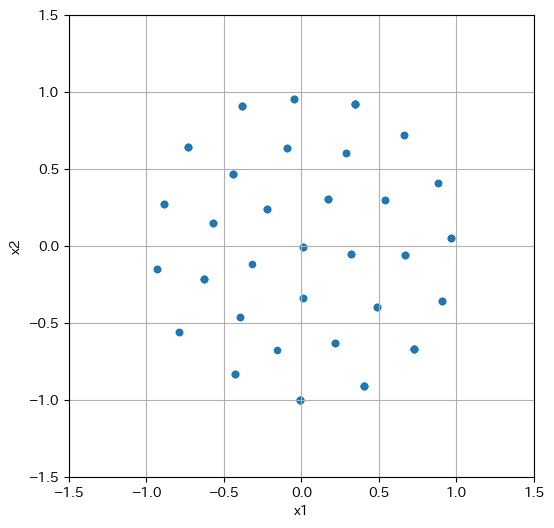

In [209]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
df.plot.scatter("x1", "x2", ax = ax)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.grid()
plt.show()